<a href="https://colab.research.google.com/github/KimEulJoong/Project_AI_Parking_Lot/blob/CRNN_OCR/AI_CRNN_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib opencv-python python-bidi arabic-reshaper --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import zipfile
import os

# 1. 구글 드라이브 마운트 (처음 한 번만 실행)
drive.mount('/content/drive')

# 2. 압축파일 경로 지정
zip_path = '/content/drive/MyDrive/OnDevice_AI/car_num.zip'  # 경로는 상황에 맞게 바꾸세요

# 3. 압축을 풀 폴더 경로 지정
extract_folder = '/content/drive/MyDrive/OnDevice_AI/car_num_unzip'

# 4. 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("압축 해제 완료:", extract_folder)

Mounted at /content/drive
압축 해제 완료: /content/drive/MyDrive/OnDevice_AI/car_num_unzip


In [ ]:
import json
import cv2
import torch
import torchvision   # ← 이 줄이 누락되어 있었음
import numpy as np
import PIL
import torch.nn as nn
import sys

print("🔧 라이브러리 버전 정보:")
print(f"Python: {'.'.join(map(str, sys.version_info[:3]))}")
print(f"OpenCV (cv2): {cv2.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"PIL (Pillow): {PIL.__version__}")
print(f"Torch.nn: {nn.__name__} (PyTorch 내부 모듈)")

🔧 라이브러리 버전 정보:
Python: 3.11.13
OpenCV (cv2): 4.11.0
PyTorch: 2.6.0+cu124
Torchvision: 0.21.0+cu124
NumPy: 2.0.2
PIL (Pillow): 11.2.1
Torch.nn: torch.nn (PyTorch 내부 모듈)


In [ ]:
import os

image_dir = "/content/drive/MyDrive/OnDevice_AI/car_num_unzip/car_num/car_num_img"
json_dir = "/content/drive/MyDrive/OnDevice_AI/car_num_unzip/car_num/car_num_json"

In [ ]:
import json
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.RandomApply([
        transforms.RandomRotation(2),                    # 글자 왜곡을 유발할 수 있으므로 2~3도 낮춤.
        transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # 미세한 이동
        transforms.GaussianBlur(kernel_size=1),          # 약간의 블러
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 변화
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class EarlyStopping:
    def __init__(self, patience=10, verbose=True):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"  🔁 No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

class OCRDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=transform):
        self.image_dir = image_dir
        self.samples = []
        self.transform = transform

        for file_name in os.listdir(json_dir):
            if not file_name.endswith(".json"):
                continue
            with open(os.path.join(json_dir, file_name), "r", encoding="utf-8") as f:
                data = json.load(f)
                image_path = os.path.join(image_dir, data["imagePath"])
                label = data["value"]
                if os.path.exists(image_path):
                    self.samples.append((image_path, label))

        # 문자 집합 구성
        self.charset = sorted(set(char for _, label in self.samples for char in label))
        self.char2idx = {char: idx + 1 for idx, char in enumerate(self.charset)}  # 0 = blank for CTC
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]

        # OpenCV로 읽기 (그레이스케일)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"⚠️ 이미지 로딩 실패: {image_path}")
            # 더미 이미지 (32x100 흰색) 반환하고, label은 공백 처리
            dummy_image = Image.fromarray(np.ones((32, 100), dtype=np.uint8) * 255)
            if self.transform:
                dummy_image = self.transform(dummy_image)
            return dummy_image, torch.tensor([], dtype=torch.long), ""

        # numpy -> PIL.Image 변환
        image = Image.fromarray(image)

        # transform이 있다면 적용
        if self.transform:
            image = self.transform(image)

        label_idx = [self.char2idx[char] for char in label]
        return image, torch.tensor(label_idx, dtype=torch.long), label


    def decode(self, preds):
        # greedy decoding
        pred_text = ''
        prev_idx = -1
        for idx in preds:
            if idx != prev_idx and idx != 0:
                pred_text += self.idx2char.get(idx.item(), '')
            prev_idx = idx
        return pred_text

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()  # output: [B, 512, 1, W]
        )

        self.rnn1 = nn.LSTM(512, 512, bidirectional=True, batch_first=True)   #원래는 512, 256
        self.rnn2 = nn.LSTM(1024, 512, bidirectional=True, batch_first=True)   #원래는 512 256
        self.fc = nn.Linear(1024, num_classes)                                 #원래는 512

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        assert h == 1, f"Expected height=1, got {h}"
        x = x.squeeze(2).permute(0, 2, 1)  # [B, W, C]

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        x = self.fc(x)                    # [B, W, C]
        x = x.permute(1, 0, 2)            # [W, B, C] = [T, B, C]   T = timescale, B = batch size, C = class amount(0,9, 가 하..+CTC Blank 포함 )
        return x

In [ ]:
from torch.nn import CTCLoss
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')


def custom_collate(batch):
    images, labels_idx, labels_str = zip(*batch)
    images = torch.stack(images)  # (B, C, H, W)

    # labels_idx는 리스트 안에 각 샘플 라벨 텐서
    targets = torch.cat(labels_idx)  # concat all target sequences

    target_lengths = torch.tensor([len(label) for label in labels_idx], dtype=torch.long)

    return images, targets, target_lengths, labels_str


dataset = OCRDataset(image_dir, json_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)


model = CRNN(num_classes=len(dataset.char2idx) + 1)  # +1 for CTC blank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

charset = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '가', '나', '다']  # 실제 문자들
char2idx = dataset.char2idx
idx_to_char = {idx: char for char, idx in char2idx.items()}

criterion = CTCLoss(blank=0, zero_infinity=True)
optimizer = Adam(model.parameters(), lr=0.0005)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def evaluate_model(model, dataloader, criterion, idx_to_char, device):
    model.eval()
    total_loss = 0
    total_chars = 0
    correct_chars = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets, target_lengths, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            outputs = model(images)
            input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

            outputs_log_softmax = outputs.log_softmax(2)
            loss = criterion(outputs_log_softmax, targets, input_lengths, target_lengths)
            total_loss += loss.item()

            # 여기서 디코딩은 배치 사이즈가 1일 때랑 다르게 처리해야 함.
            # 일단 배치 1개씩 처리하는 예시:

            for b in range(images.size(0)):
                preds = torch.argmax(outputs[:, b, :], dim=1).cpu().numpy().tolist()

                decoded = []
                prev = -1
                for p in preds:
                    if p != prev and p != 0:
                        decoded.append(p)
                    prev = p
                pred_text = ''.join([idx_to_char[i] for i in decoded])

                start_idx = sum(target_lengths[:b])
                end_idx = start_idx + target_lengths[b].item()
                true_text = ''.join([idx_to_char[i.item()] for i in targets[start_idx:end_idx]])

                min_len = min(len(pred_text), len(true_text))
                correct_chars += sum([pred_text[i] == true_text[i] for i in range(min_len)])
                total_chars += len(true_text)

                for t_char, p_char in zip(true_text, pred_text):
                    y_true.append(t_char)
                    y_pred.append(p_char)

    acc = correct_chars / total_chars if total_chars else 0
    prec = precision_score(y_true, y_pred, average='micro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='micro', zero_division=0)

    return total_loss, acc, prec, rec

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score

def pad_labels(labels):
    max_len = max(len(label) for label in labels)
    padded = torch.zeros(len(labels), max_len, dtype=torch.long)
    for i, label in enumerate(labels):
        padded[i, :len(label)] = label
    return padded

# 에폭마다 기록된 값들을 저장할 리스트
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=15)  # 원하는 patience 설정


for epoch in range(200):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        images, targets, target_lengths, _ = batch
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, criterion, idx_to_char, device)

    # 결과 저장
    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")

    # 🔽 학습률 자동 감소
    scheduler.step(val_loss)

    # ⏹️ 조기 종료 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("🛑 Early stopping triggered")
        break


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 108/108 [00:16<00:00,  6.55it/s]


[Epoch 1] Train Loss: 329.5030 | Val Loss: 81.6990 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 108/108 [00:15<00:00,  7.12it/s]


[Epoch 2] Train Loss: 319.5239 | Val Loss: 78.4482 | Acc: 0.0689 | Precision: 0.4825 | Recall: 0.4825


100%|██████████| 108/108 [00:15<00:00,  6.83it/s]


[Epoch 3] Train Loss: 311.2322 | Val Loss: 77.7782 | Acc: 0.1072 | Precision: 0.3753 | Recall: 0.3753


100%|██████████| 108/108 [00:15<00:00,  7.11it/s]


[Epoch 4] Train Loss: 308.2032 | Val Loss: 76.5493 | Acc: 0.1072 | Precision: 0.3753 | Recall: 0.3753


100%|██████████| 108/108 [00:14<00:00,  7.26it/s]


[Epoch 5] Train Loss: 302.7108 | Val Loss: 74.7799 | Acc: 0.1072 | Precision: 0.3753 | Recall: 0.3753


100%|██████████| 108/108 [00:15<00:00,  7.16it/s]


[Epoch 6] Train Loss: 286.4514 | Val Loss: 70.2271 | Acc: 0.1072 | Precision: 0.2502 | Recall: 0.2502


100%|██████████| 108/108 [00:15<00:00,  6.92it/s]


[Epoch 7] Train Loss: 276.5013 | Val Loss: 68.7107 | Acc: 0.1072 | Precision: 0.2502 | Recall: 0.2502


100%|██████████| 108/108 [00:15<00:00,  7.11it/s]


[Epoch 8] Train Loss: 271.8260 | Val Loss: 67.3803 | Acc: 0.1195 | Precision: 0.2092 | Recall: 0.2092


100%|██████████| 108/108 [00:15<00:00,  7.19it/s]


[Epoch 9] Train Loss: 268.4476 | Val Loss: 66.3502 | Acc: 0.1322 | Precision: 0.1851 | Recall: 0.1851


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


[Epoch 10] Train Loss: 265.4934 | Val Loss: 66.7037 | Acc: 0.1399 | Precision: 0.1958 | Recall: 0.1958
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


[Epoch 11] Train Loss: 253.9115 | Val Loss: 62.1370 | Acc: 0.0936 | Precision: 0.1310 | Recall: 0.1310


100%|██████████| 108/108 [00:17<00:00,  6.20it/s]


[Epoch 12] Train Loss: 250.5390 | Val Loss: 62.0812 | Acc: 0.1029 | Precision: 0.1441 | Recall: 0.1441


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 13] Train Loss: 249.0869 | Val Loss: 62.1300 | Acc: 0.1658 | Precision: 0.1935 | Recall: 0.1935
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]


[Epoch 14] Train Loss: 250.2048 | Val Loss: 62.2886 | Acc: 0.0956 | Precision: 0.1338 | Recall: 0.1338
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


[Epoch 15] Train Loss: 249.4675 | Val Loss: 61.9741 | Acc: 0.1029 | Precision: 0.1441 | Recall: 0.1441


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 16] Train Loss: 249.9923 | Val Loss: 62.3290 | Acc: 0.1662 | Precision: 0.1939 | Recall: 0.1939
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.24it/s]


[Epoch 17] Train Loss: 247.1819 | Val Loss: 61.1886 | Acc: 0.2078 | Precision: 0.2424 | Recall: 0.2424


100%|██████████| 108/108 [00:14<00:00,  7.27it/s]


[Epoch 18] Train Loss: 242.2582 | Val Loss: 65.0819 | Acc: 0.1525 | Precision: 0.1783 | Recall: 0.1783
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 19] Train Loss: 237.7669 | Val Loss: 66.6778 | Acc: 0.2005 | Precision: 0.2331 | Recall: 0.2331
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:15<00:00,  7.16it/s]


[Epoch 20] Train Loss: 234.7432 | Val Loss: 58.6130 | Acc: 0.2361 | Precision: 0.2813 | Recall: 0.2813


100%|██████████| 108/108 [00:14<00:00,  7.34it/s]


[Epoch 21] Train Loss: 234.1781 | Val Loss: 57.8138 | Acc: 0.2641 | Precision: 0.3084 | Recall: 0.3084


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 22] Train Loss: 231.6977 | Val Loss: 57.3682 | Acc: 0.2567 | Precision: 0.3000 | Recall: 0.3000


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 23] Train Loss: 229.2468 | Val Loss: 56.9631 | Acc: 0.2601 | Precision: 0.3040 | Recall: 0.3040


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 24] Train Loss: 226.4536 | Val Loss: 56.1546 | Acc: 0.2787 | Precision: 0.3262 | Recall: 0.3262


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]


[Epoch 25] Train Loss: 224.3319 | Val Loss: 58.3372 | Acc: 0.2448 | Precision: 0.2880 | Recall: 0.2880
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.26it/s]


[Epoch 26] Train Loss: 222.2868 | Val Loss: 56.1566 | Acc: 0.2727 | Precision: 0.3181 | Recall: 0.3181
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]


[Epoch 27] Train Loss: 221.4404 | Val Loss: 55.2359 | Acc: 0.3017 | Precision: 0.3445 | Recall: 0.3445


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 28] Train Loss: 219.2927 | Val Loss: 54.8510 | Acc: 0.2804 | Precision: 0.3274 | Recall: 0.3274


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


[Epoch 29] Train Loss: 217.7787 | Val Loss: 54.0122 | Acc: 0.3060 | Precision: 0.3505 | Recall: 0.3505


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


[Epoch 30] Train Loss: 215.6746 | Val Loss: 53.3616 | Acc: 0.3067 | Precision: 0.3522 | Recall: 0.3522


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 31] Train Loss: 212.1872 | Val Loss: 52.7439 | Acc: 0.3097 | Precision: 0.3525 | Recall: 0.3525


100%|██████████| 108/108 [00:14<00:00,  7.52it/s]


[Epoch 32] Train Loss: 208.6392 | Val Loss: 50.5364 | Acc: 0.3400 | Precision: 0.3596 | Recall: 0.3596


100%|██████████| 108/108 [00:14<00:00,  7.32it/s]


[Epoch 33] Train Loss: 195.8500 | Val Loss: 49.5685 | Acc: 0.3247 | Precision: 0.3305 | Recall: 0.3305


100%|██████████| 108/108 [00:14<00:00,  7.29it/s]


[Epoch 34] Train Loss: 191.1991 | Val Loss: 49.1035 | Acc: 0.3616 | Precision: 0.3690 | Recall: 0.3690


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 35] Train Loss: 185.8225 | Val Loss: 46.2528 | Acc: 0.3943 | Precision: 0.3987 | Recall: 0.3987


100%|██████████| 108/108 [00:14<00:00,  7.35it/s]


[Epoch 36] Train Loss: 180.0456 | Val Loss: 44.8812 | Acc: 0.4216 | Precision: 0.4258 | Recall: 0.4258


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 37] Train Loss: 174.2180 | Val Loss: 44.5434 | Acc: 0.4296 | Precision: 0.4319 | Recall: 0.4319


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]


[Epoch 38] Train Loss: 168.7266 | Val Loss: 42.7047 | Acc: 0.4459 | Precision: 0.4495 | Recall: 0.4495


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 39] Train Loss: 163.4101 | Val Loss: 42.4339 | Acc: 0.4456 | Precision: 0.4478 | Recall: 0.4478


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 40] Train Loss: 157.3030 | Val Loss: 41.0906 | Acc: 0.4662 | Precision: 0.4717 | Recall: 0.4717


100%|██████████| 108/108 [00:14<00:00,  7.28it/s]


[Epoch 41] Train Loss: 150.5590 | Val Loss: 37.8649 | Acc: 0.5165 | Precision: 0.5210 | Recall: 0.5210


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]


[Epoch 42] Train Loss: 144.2752 | Val Loss: 38.4844 | Acc: 0.5055 | Precision: 0.5092 | Recall: 0.5092
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 43] Train Loss: 138.7733 | Val Loss: 36.5202 | Acc: 0.5295 | Precision: 0.5316 | Recall: 0.5316


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]


[Epoch 44] Train Loss: 130.3403 | Val Loss: 33.3691 | Acc: 0.5734 | Precision: 0.5757 | Recall: 0.5757


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]


[Epoch 45] Train Loss: 125.8897 | Val Loss: 32.6948 | Acc: 0.5921 | Precision: 0.5945 | Recall: 0.5945


100%|██████████| 108/108 [00:14<00:00,  7.36it/s]


[Epoch 46] Train Loss: 120.9072 | Val Loss: 31.3866 | Acc: 0.6184 | Precision: 0.6194 | Recall: 0.6194


100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


[Epoch 47] Train Loss: 114.5054 | Val Loss: 30.3798 | Acc: 0.6180 | Precision: 0.6205 | Recall: 0.6205


100%|██████████| 108/108 [00:14<00:00,  7.29it/s]


[Epoch 48] Train Loss: 107.7863 | Val Loss: 30.9404 | Acc: 0.6161 | Precision: 0.6185 | Recall: 0.6185
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]


[Epoch 49] Train Loss: 101.9355 | Val Loss: 28.1675 | Acc: 0.6593 | Precision: 0.6611 | Recall: 0.6611


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


[Epoch 50] Train Loss: 97.0103 | Val Loss: 27.5698 | Acc: 0.6670 | Precision: 0.6683 | Recall: 0.6683


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 51] Train Loss: 90.1370 | Val Loss: 25.7900 | Acc: 0.6863 | Precision: 0.6881 | Recall: 0.6881


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 52] Train Loss: 86.4019 | Val Loss: 25.2581 | Acc: 0.7010 | Precision: 0.7033 | Recall: 0.7033


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 53] Train Loss: 85.5568 | Val Loss: 23.3527 | Acc: 0.7189 | Precision: 0.7213 | Recall: 0.7213


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]


[Epoch 54] Train Loss: 76.0407 | Val Loss: 25.1889 | Acc: 0.6963 | Precision: 0.6977 | Recall: 0.6977
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 55] Train Loss: 87.9091 | Val Loss: 23.7303 | Acc: 0.7146 | Precision: 0.7156 | Recall: 0.7156
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.48it/s]


[Epoch 56] Train Loss: 74.7609 | Val Loss: 22.0889 | Acc: 0.7356 | Precision: 0.7381 | Recall: 0.7381


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]


[Epoch 57] Train Loss: 64.9125 | Val Loss: 20.5475 | Acc: 0.7532 | Precision: 0.7553 | Recall: 0.7553


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 58] Train Loss: 58.9119 | Val Loss: 19.7778 | Acc: 0.7672 | Precision: 0.7688 | Recall: 0.7688


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]


[Epoch 59] Train Loss: 55.9504 | Val Loss: 19.9897 | Acc: 0.7619 | Precision: 0.7642 | Recall: 0.7642
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


[Epoch 60] Train Loss: 55.2023 | Val Loss: 20.9303 | Acc: 0.7529 | Precision: 0.7547 | Recall: 0.7547
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 61] Train Loss: 50.5970 | Val Loss: 19.2262 | Acc: 0.7786 | Precision: 0.7793 | Recall: 0.7793


100%|██████████| 108/108 [00:15<00:00,  7.09it/s]


[Epoch 62] Train Loss: 45.3053 | Val Loss: 18.5428 | Acc: 0.7872 | Precision: 0.7885 | Recall: 0.7885


100%|██████████| 108/108 [00:14<00:00,  7.33it/s]


[Epoch 63] Train Loss: 43.8875 | Val Loss: 20.4786 | Acc: 0.7682 | Precision: 0.7693 | Recall: 0.7693
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 64] Train Loss: 46.0118 | Val Loss: 17.3075 | Acc: 0.8029 | Precision: 0.8045 | Recall: 0.8045


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 65] Train Loss: 38.4334 | Val Loss: 18.6446 | Acc: 0.7965 | Precision: 0.7981 | Recall: 0.7981
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.52it/s]


[Epoch 66] Train Loss: 36.0631 | Val Loss: 17.9513 | Acc: 0.7992 | Precision: 0.8027 | Recall: 0.8027
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]


[Epoch 67] Train Loss: 32.8680 | Val Loss: 17.7890 | Acc: 0.8012 | Precision: 0.8025 | Recall: 0.8025
  🔁 No improvement (3/15)


100%|██████████| 108/108 [00:14<00:00,  7.55it/s]


[Epoch 68] Train Loss: 31.9689 | Val Loss: 17.2061 | Acc: 0.8129 | Precision: 0.8139 | Recall: 0.8139


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]


[Epoch 69] Train Loss: 30.9306 | Val Loss: 16.5358 | Acc: 0.8099 | Precision: 0.8120 | Recall: 0.8120


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]


[Epoch 70] Train Loss: 27.9625 | Val Loss: 16.6423 | Acc: 0.8185 | Precision: 0.8196 | Recall: 0.8196
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]


[Epoch 71] Train Loss: 31.6675 | Val Loss: 17.0534 | Acc: 0.8202 | Precision: 0.8205 | Recall: 0.8205
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 72] Train Loss: 26.8862 | Val Loss: 16.1289 | Acc: 0.8215 | Precision: 0.8232 | Recall: 0.8232


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]


[Epoch 73] Train Loss: 26.4004 | Val Loss: 16.6176 | Acc: 0.8195 | Precision: 0.8206 | Recall: 0.8206
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.58it/s]


[Epoch 74] Train Loss: 22.4040 | Val Loss: 16.0602 | Acc: 0.8288 | Precision: 0.8299 | Recall: 0.8299


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]


[Epoch 75] Train Loss: 18.9769 | Val Loss: 16.7820 | Acc: 0.8245 | Precision: 0.8251 | Recall: 0.8251
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]


[Epoch 76] Train Loss: 20.0563 | Val Loss: 15.9403 | Acc: 0.8262 | Precision: 0.8284 | Recall: 0.8284


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]


[Epoch 77] Train Loss: 18.4752 | Val Loss: 15.9033 | Acc: 0.8388 | Precision: 0.8397 | Recall: 0.8397


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 78] Train Loss: 16.3596 | Val Loss: 16.6360 | Acc: 0.8298 | Precision: 0.8312 | Recall: 0.8312
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.60it/s]


[Epoch 79] Train Loss: 16.8926 | Val Loss: 16.0652 | Acc: 0.8295 | Precision: 0.8312 | Recall: 0.8312
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]


[Epoch 80] Train Loss: 18.5042 | Val Loss: 16.6993 | Acc: 0.8298 | Precision: 0.8312 | Recall: 0.8312
  🔁 No improvement (3/15)


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]


[Epoch 81] Train Loss: 14.6327 | Val Loss: 16.6467 | Acc: 0.8332 | Precision: 0.8346 | Recall: 0.8346
  🔁 No improvement (4/15)


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 82] Train Loss: 13.7253 | Val Loss: 15.9727 | Acc: 0.8428 | Precision: 0.8439 | Recall: 0.8439
  🔁 No improvement (5/15)


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]


[Epoch 83] Train Loss: 14.7417 | Val Loss: 15.6866 | Acc: 0.8478 | Precision: 0.8492 | Recall: 0.8492


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]


[Epoch 84] Train Loss: 14.9898 | Val Loss: 16.6741 | Acc: 0.8312 | Precision: 0.8323 | Recall: 0.8323
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 85] Train Loss: 12.9558 | Val Loss: 15.6493 | Acc: 0.8442 | Precision: 0.8450 | Recall: 0.8450


100%|██████████| 108/108 [00:14<00:00,  7.45it/s]


[Epoch 86] Train Loss: 12.3347 | Val Loss: 17.3740 | Acc: 0.8305 | Precision: 0.8324 | Recall: 0.8324
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.43it/s]


[Epoch 87] Train Loss: 12.1923 | Val Loss: 16.4166 | Acc: 0.8378 | Precision: 0.8395 | Recall: 0.8395
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]


[Epoch 88] Train Loss: 16.1196 | Val Loss: 16.1397 | Acc: 0.8372 | Precision: 0.8386 | Recall: 0.8386
  🔁 No improvement (3/15)


100%|██████████| 108/108 [00:14<00:00,  7.28it/s]


[Epoch 89] Train Loss: 11.3116 | Val Loss: 15.2419 | Acc: 0.8535 | Precision: 0.8546 | Recall: 0.8546


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]


[Epoch 90] Train Loss: 11.0095 | Val Loss: 17.6167 | Acc: 0.8292 | Precision: 0.8306 | Recall: 0.8306
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]


[Epoch 91] Train Loss: 10.3651 | Val Loss: 17.5940 | Acc: 0.8355 | Precision: 0.8369 | Recall: 0.8369
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.49it/s]


[Epoch 92] Train Loss: 19.1929 | Val Loss: 16.3128 | Acc: 0.8398 | Precision: 0.8407 | Recall: 0.8407
  🔁 No improvement (3/15)


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]


[Epoch 93] Train Loss: 17.1206 | Val Loss: 16.1574 | Acc: 0.8408 | Precision: 0.8419 | Recall: 0.8419
  🔁 No improvement (4/15)


100%|██████████| 108/108 [00:14<00:00,  7.59it/s]


[Epoch 94] Train Loss: 9.8562 | Val Loss: 15.0797 | Acc: 0.8548 | Precision: 0.8557 | Recall: 0.8557


100%|██████████| 108/108 [00:14<00:00,  7.56it/s]


[Epoch 95] Train Loss: 8.2745 | Val Loss: 16.3086 | Acc: 0.8488 | Precision: 0.8497 | Recall: 0.8497
  🔁 No improvement (1/15)


100%|██████████| 108/108 [00:14<00:00,  7.50it/s]


[Epoch 96] Train Loss: 8.2246 | Val Loss: 15.5704 | Acc: 0.8525 | Precision: 0.8542 | Recall: 0.8542
  🔁 No improvement (2/15)


100%|██████████| 108/108 [00:14<00:00,  7.44it/s]


[Epoch 97] Train Loss: 7.3096 | Val Loss: 16.2834 | Acc: 0.8535 | Precision: 0.8543 | Recall: 0.8543
  🔁 No improvement (3/15)


100%|██████████| 108/108 [00:14<00:00,  7.51it/s]


[Epoch 98] Train Loss: 7.0306 | Val Loss: 15.7218 | Acc: 0.8575 | Precision: 0.8583 | Recall: 0.8583
  🔁 No improvement (4/15)


100%|██████████| 108/108 [00:14<00:00,  7.47it/s]


[Epoch 99] Train Loss: 6.1305 | Val Loss: 17.1607 | Acc: 0.8498 | Precision: 0.8507 | Recall: 0.8507
  🔁 No improvement (5/15)


100%|██████████| 108/108 [00:14<00:00,  7.21it/s]


[Epoch 100] Train Loss: 7.6839 | Val Loss: 15.8203 | Acc: 0.8508 | Precision: 0.8520 | Recall: 0.8520
  🔁 No improvement (6/15)


100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


[Epoch 101] Train Loss: 5.5982 | Val Loss: 15.5173 | Acc: 0.8571 | Precision: 0.8586 | Recall: 0.8586
  🔁 No improvement (7/15)


100%|██████████| 108/108 [00:14<00:00,  7.46it/s]


[Epoch 102] Train Loss: 4.6055 | Val Loss: 15.6211 | Acc: 0.8661 | Precision: 0.8664 | Recall: 0.8664
  🔁 No improvement (8/15)


100%|██████████| 108/108 [00:14<00:00,  7.26it/s]


[Epoch 103] Train Loss: 4.0581 | Val Loss: 15.7337 | Acc: 0.8585 | Precision: 0.8599 | Recall: 0.8599
  🔁 No improvement (9/15)


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]


[Epoch 104] Train Loss: 3.4399 | Val Loss: 15.6246 | Acc: 0.8618 | Precision: 0.8624 | Recall: 0.8624
  🔁 No improvement (10/15)


100%|██████████| 108/108 [00:14<00:00,  7.53it/s]


[Epoch 105] Train Loss: 4.7072 | Val Loss: 15.9078 | Acc: 0.8541 | Precision: 0.8553 | Recall: 0.8553
  🔁 No improvement (11/15)


100%|██████████| 108/108 [00:14<00:00,  7.29it/s]


[Epoch 106] Train Loss: 5.3858 | Val Loss: 15.5084 | Acc: 0.8625 | Precision: 0.8628 | Recall: 0.8628
  🔁 No improvement (12/15)


100%|██████████| 108/108 [00:14<00:00,  7.34it/s]


[Epoch 107] Train Loss: 3.4713 | Val Loss: 15.9047 | Acc: 0.8628 | Precision: 0.8634 | Recall: 0.8634
  🔁 No improvement (13/15)


100%|██████████| 108/108 [00:14<00:00,  7.54it/s]


[Epoch 108] Train Loss: 2.7276 | Val Loss: 15.3191 | Acc: 0.8615 | Precision: 0.8618 | Recall: 0.8618
  🔁 No improvement (14/15)


100%|██████████| 108/108 [00:14<00:00,  7.41it/s]


[Epoch 109] Train Loss: 2.6214 | Val Loss: 15.9162 | Acc: 0.8651 | Precision: 0.8657 | Recall: 0.8657
  🔁 No improvement (15/15)
🛑 Early stopping triggered


In [ ]:
model.eval()
with torch.no_grad():
    for i in range(30):
        image, label_idx, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        pred_indices = output.argmax(dim=2)  # shape: (seq_len, batch_size)
        pred_text = dataset.decode(pred_indices)
        print(f"[GT] {label} → [Pred] {pred_text}")

[GT] 01가0785 → [Pred] 01가0785
[GT] 01가0865 → [Pred] 01가0864
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1366 → [Pred] 01가1366
[GT] 01가1366 → [Pred] 01가1366
[GT] 01가1705 → [Pred] 01가1705
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2246 → [Pred] 01가2246
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2512 → [Pred] 01가2512
[GT] 01가2525 → [Pred] 01가2525
[GT] 01가2567 → [Pred] 01가2567
[GT] 01가2636 → [Pred] 01가2636
[GT] 01가3005 → [Pred] 01가3005
[GT] 01가3042 → [Pred] 01가3042
[GT] 01가3315 → [Pred] 01가3315
[GT] 01가3372 → [Pred] 01가3372
[GT] 01가3372 → [Pred] 01가3372


In [ ]:
def ctc_decode(pred_indices, blank=0):
    decoded = []
    prev = None
    for idx in pred_indices:
        if idx != blank and idx != prev:
            decoded.append(idx)
        prev = idx
    return decoded

decoded_indices = ctc_decode(pred_indices[:, 0].tolist(), blank=0)
print("Decoded indices:", decoded_indices)

Decoded indices: [1, 2, 11, 4, 4, 8, 3]


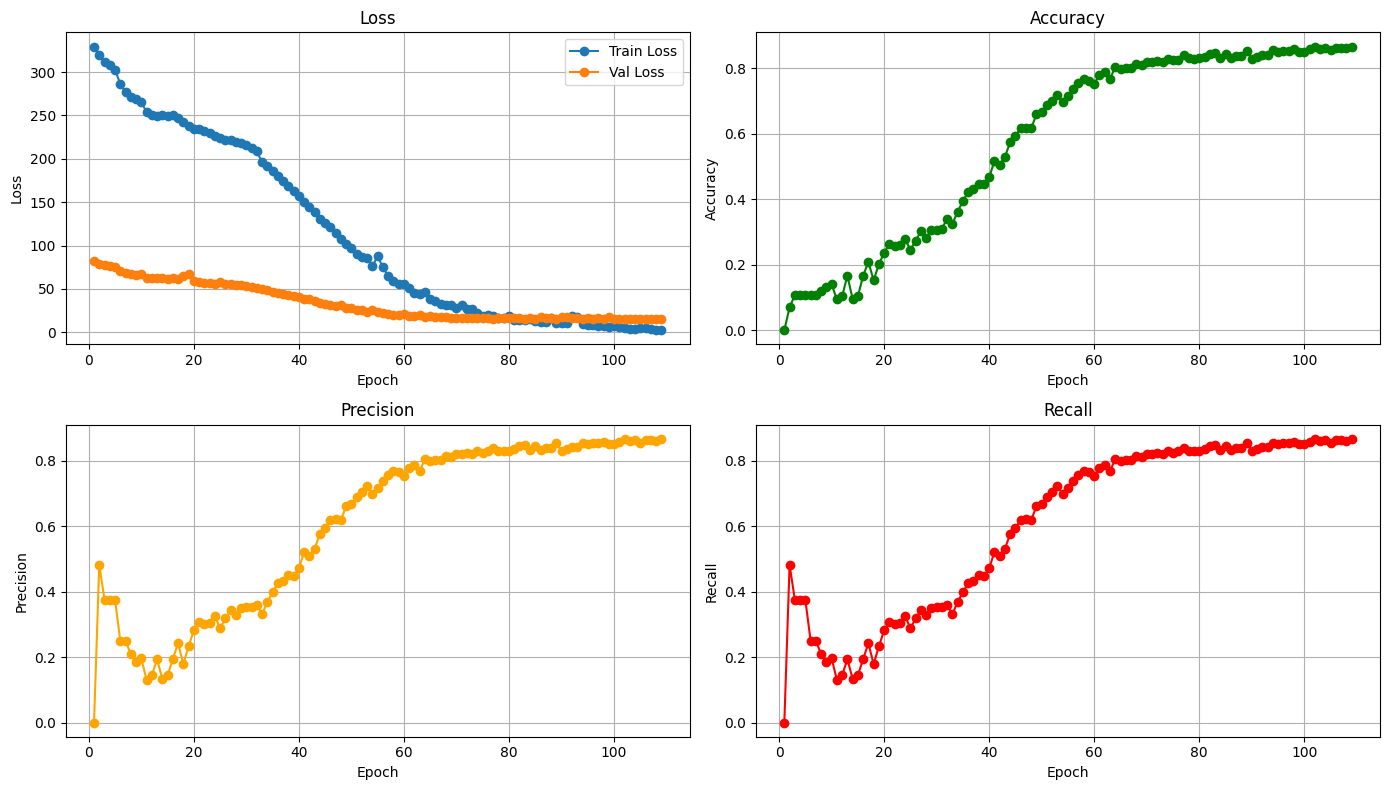

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, label='Accuracy', color='green', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, val_precisions, label='Precision', color='orange', marker='o')
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, val_recalls, label='Recall', color='red', marker='o')
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()